Time Series Analysis
- Sales trends over time for each item
- forecasting:
    - Built arima models for each individual item using monthly sales data.
    - Forecasted future sales for the next 6 months.
    - Visualized both historical and predicted values using Plotly charts.


CF:
- Created a user-item review matrix (customers × clothing items).
- Used cosine similarity to compute item-item similarity based on review patterns.
- Built a tool to recommend items similar to any given product.
    - Hybrid Bundling (Co-purchase + Similarity):
        - Constructed a co-purchase matrix to see which items are bought together.
        - Combined this with cosine similarity scores to create a hybrid bundle ranking.
        - Generated top 3 bundle suggestions for every item.


## CLEANED UP

In [1]:
# import libraries
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from ipywidgets import interact, widgets, Dropdown, interactive, IntSlider
from statsmodels.tsa.arima.model import ARIMA
import warnings
from IPython.display import display
warnings.filterwarnings("ignore")

In [2]:
# define clothing items for filtering
clothing_items = [
    'Tunic', 'Tank Top', 'Leggings', 'Onesie', 'Jacket', 'Trousers', 'Jeans',
    'Pajamas', 'Trench Coat', 'Poncho', 'Romper', 'T-shirt', 'Shorts',
    'Blazer', 'Hoodie', 'Sweater', 'Blouse', 'Swimsuit', 'Kimono', 'Cardigan',
    'Dress', 'Camisole', 'Flannel Shirt', 'Polo Shirt', 'Overalls', 'Coat',
    'Vest', 'Jumpsuit', 'Raincoat', 'Skirt', 'Pants'
]

# function to load and preprocess dataset
def load_and_clean_data(csv_path="retail_sales.csv"):
    df = pd.read_csv(csv_path)
    df['date'] = pd.to_datetime(df['date'])
    df = df.dropna(subset=['amount_usd'])
    df['month'] = df['date'].dt.to_period('M').dt.to_timestamp()
    df = df[df['item'].isin(clothing_items)].copy()
    return df

# load once and reuse
df = load_and_clean_data()
df

,customerID,item,amount_usd,date,review,payment,month
1,4115,Tunic,2456.0,2023-07-11,2.0,Credit Card,2023-07-01
2,4019,Tank Top,2102.0,2023-03-23,4.1,Cash,2023-03-01
3,4097,Leggings,3126.0,2023-03-15,3.2,Cash,2023-03-01
5,4080,Onesie,2914.0,2022-12-11,4.5,Credit Card,2022-12-01
6,4055,Jacket,2571.0,2023-07-08,1.3,Cash,2023-07-01
...,...,...,...,...,...,...,...
3388,4094,Trench Coat,17.0,2023-02-13,2.5,Credit Card,2023-02-01
3392,3981,Sweater,99.0,2022-10-25,4.5,Cash,2022-10-01
3393,4110,Polo Shirt,42.0,2022-10-15,4.0,Cash,2022-10-01
3394,4040,Tank Top,113.0,2023-01-20,1.2,Credit Card,2023-01-01


In [3]:
# # define clothing items for filtering
# clothing_items = [
#     'Tunic', 'Tank Top', 'Leggings', 'Onesie', 'Jacket', 'Trousers', 'Jeans',
#     'Pajamas', 'Trench Coat', 'Poncho', 'Romper', 'T-shirt', 'Shorts',
#     'Blazer', 'Hoodie', 'Sweater', 'Blouse', 'Swimsuit', 'Kimono', 'Cardigan',
#     'Dress', 'Camisole', 'Flannel Shirt', 'Polo Shirt', 'Overalls', 'Coat',
#     'Vest', 'Jumpsuit', 'Raincoat', 'Skirt', 'Pants'
# ]

# # function to load and preprocess dataset
# def load_and_clean_data(csv_path="retail_sales.csv"):
#     df = pd.read_csv(csv_path)
#     df['date'] = pd.to_datetime(df['date'])
#     df = df.dropna(subset=['amount_usd'])
#     df['review'] = df.groupby('item')['review'].transform(lambda x: x.fillna(x.mean()))
#     df['amount_usd'] = df.groupby('item')['amount_usd'].transform(lambda x: x.fillna(x.mean()))
#     df['month'] = df['date'].dt.to_period('M').dt.to_timestamp()
#     df = df[df['item'].isin(clothing_items)].copy()
#     return df

# # load once and reuse
# df = load_and_clean_data()
# df

In [4]:
user_item_matrix = df.pivot_table(index='customerID', columns='item', values='review', aggfunc='mean')

# center by item, keeping NaN values
item_mat = user_item_matrix.to_numpy()
item_means = np.nanmean(item_mat, axis=0)
item_mat_centered = item_mat - item_means  

# get cosine similarity
item_names = user_item_matrix.columns
n_items = item_mat_centered.shape[1]
item_similarity_df = pd.DataFrame(index=item_names, columns=item_names, dtype=float)

for i in range(n_items):
    for j in range(n_items):
        vec_i = item_mat_centered[:, i]
        vec_j = item_mat_centered[:, j]

        shared = ~np.isnan(vec_i) & ~np.isnan(vec_j)

        if np.sum(shared) > 1:
            sim = cosine_similarity(vec_i[shared].reshape(1, -1), vec_j[shared].reshape(1, -1))[0, 0]
        else:
            sim = np.nan

        item_similarity_df.iloc[i, j] = sim

item_similarity_df

item,Blazer,Blouse,Camisole,Cardigan,Coat,Dress,Flannel Shirt,Hoodie,Jacket,Jeans,...,Shorts,Skirt,Sweater,Swimsuit,T-shirt,Tank Top,Trench Coat,Trousers,Tunic,Vest
item,,,,,,,,,,,,,,,,,,,,,
Blazer,1.000000,0.677718,-0.037996,-0.381059,0.259027,0.075455,0.065506,0.129767,0.111952,0.444099,...,-0.041236,0.185372,0.316087,-0.815436,0.020859,0.375784,-0.414125,0.149659,0.173674,0.163911
Blouse,0.677718,1.000000,-0.132301,-0.099889,-0.019207,-0.237407,0.268434,0.192684,0.678368,0.420295,...,0.557906,-0.467093,0.145350,-0.354217,0.127414,-0.227700,-0.024790,0.265876,-0.011705,0.088511
Camisole,-0.037996,-0.132301,1.000000,0.551967,0.191293,0.370939,0.450536,0.142072,-0.127248,0.269746,...,0.291170,0.015149,-0.128844,0.244543,0.278620,0.076199,0.554679,0.530316,-0.100148,-0.215002
Cardigan,-0.381059,-0.099889,0.551967,1.000000,0.028160,0.503560,0.112417,-0.078554,-0.168655,-0.401371,...,-0.320418,-0.054592,-0.287373,-0.086917,0.307243,-0.106317,0.045457,-0.529594,-0.420337,-0.235136
Coat,0.259027,-0.019207,0.191293,0.028160,1.000000,-0.322930,0.232293,0.212548,-0.591009,-0.101388,...,0.401304,-0.097370,-0.746964,0.194417,0.400585,0.476120,-0.199583,-0.386298,0.514497,0.036707
Dress,0.075455,-0.237407,0.370939,0.503560,-0.322930,1.000000,0.460615,-0.147796,0.126762,-0.223350,...,-0.077824,0.177587,-0.200839,-0.247195,-0.274455,0.093641,-0.067333,-0.116785,-0.209936,-0.462404
Flannel Shirt,0.065506,0.268434,0.450536,0.112417,0.232293,0.460615,1.000000,-0.276135,0.250968,-0.079775,...,0.285695,0.381191,0.171085,0.313272,-0.349990,0.089183,-0.172733,0.332862,0.291815,0.102135
Hoodie,0.129767,0.192684,0.142072,-0.078554,0.212548,-0.147796,-0.276135,1.000000,0.079161,0.164329,...,0.060627,-0.108036,-0.049701,0.553818,0.105800,-0.233260,0.218107,-0.152044,-0.051573,-0.158084
Jacket,0.111952,0.678368,-0.127248,-0.168655,-0.591009,0.126762,0.250968,0.079161,1.000000,0.479647,...,-0.471869,-0.045201,0.425864,0.076841,-0.488099,-0.443067,-0.352852,0.323329,-0.109550,0.125123


In [5]:
item_mat

array([[nan, 2.1, 4.7, ..., nan, nan, 3.2],
       [nan, 3.3, nan, ..., nan, 1.1, nan],
       [1.8, nan, nan, ..., 4.5, nan, nan],
       ...,
       [nan, nan, nan, ..., 2. , 1.2, nan],
       [nan, 4.6, nan, ..., 3.4, nan, nan],
       [4.6, nan, 4.2, ..., nan, nan, nan]])

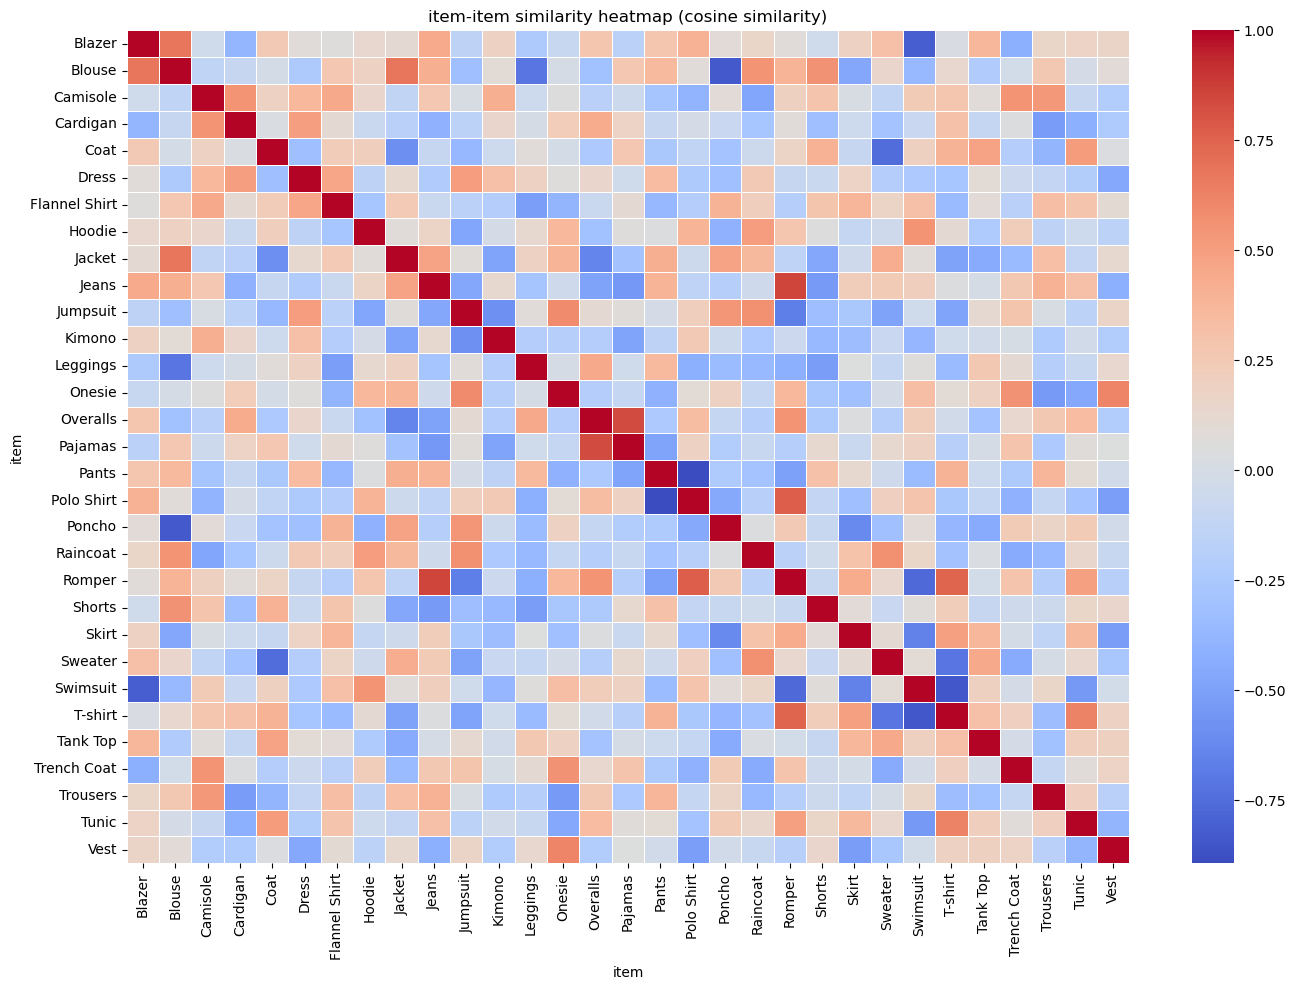

In [6]:
# plot heatmap of item similarity
plt.figure(figsize=(14, 10))
sns.heatmap(item_similarity_df, cmap="coolwarm", annot=False, fmt=".2f", linewidths=0.5,
            xticklabels=item_similarity_df.columns, yticklabels=item_similarity_df.index)
plt.title("item-item similarity heatmap (cosine similarity)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("item-item-heatmap.png", bbox_inches='tight')
plt.show()

In [7]:
# function to find and print top-n similar items based on cosine similarity
def find_similar_items(item_name, top_n=5):
    # convert input to lowercase for case-insensitive matching
    item_name_lower = item_name.lower()
    all_items = list(item_similarity_df.columns)
    
    # match the input item ignoring case
    matched_items = [item for item in all_items if item.lower() == item_name_lower]
    
    if not matched_items:
        print(f"item '{item_name}' not found. please check the spelling or try another item.")
        return
    
    matched_item = matched_items[0]
    
    # get top n similar items
    similar_items = item_similarity_df[matched_item].drop(matched_item).sort_values(ascending=False).head(top_n)
    print(f"\ntop {top_n} items similar to '{matched_item}':")
    for similar_item, score in similar_items.items():
        print(f"{similar_item}: similarity score = {score:.2f}")

# prompt user to input item and number of similar items to display
user_input = input("enter an item name to find similar products: ").strip()
n = int(input("how many similar items do you want to see? (default 5): ") or 5)

find_similar_items(user_input, top_n=n)



top 4 items similar to 'Hoodie':
Swimsuit: similarity score = 0.55
Raincoat: similarity score = 0.51
Polo Shirt: similarity score = 0.39
Onesie: similarity score = 0.37


In [8]:
# count total number of sales
total_sales = len(df)

# count number of unique items
unique_items = df['item'].nunique()

# count item frequency
item_counts = df['item'].value_counts()

# display results
print(f"\ntotal number of sales: {total_sales}")
print(f"number of unique items: {unique_items}")
print("\nitems sold (sorted by quantity):")
print(item_counts)



total number of sales: 1731
number of unique items: 31

items sold (sorted by quantity):
item
Shorts           74
Pants            71
Skirt            70
Tank Top         66
T-shirt          63
Hoodie           62
Camisole         62
Cardigan         61
Pajamas          61
Kimono           61
Poncho           60
Onesie           59
Vest             58
Blouse           57
Trench Coat      56
Raincoat         55
Overalls         54
Tunic            54
Blazer           54
Flannel Shirt    53
Coat             52
Sweater          51
Jacket           50
Swimsuit         49
Leggings         49
Romper           48
Jeans            48
Jumpsuit         46
Dress            44
Polo Shirt       43
Trousers         40
Name: count, dtype: int64


In [9]:
# group by item and month: sum of sales and units sold
ts_sales_full = df.groupby(['item', 'month']).agg(
    Total_Sales=('amount_usd', 'sum'),
    Units_Sold=('item', 'count')
).reset_index()

# dropdown options
items_list = sorted(ts_sales_full['item'].unique())

# plot function
def plot_multiple_items(selected_items):
    if not selected_items:
        return  # avoid rendering if nothing is selected
    
    fig = go.Figure()
    for item in selected_items:
        item_data = ts_sales_full[ts_sales_full['item'] == item]
        fig.add_trace(go.Scatter(
            x=item_data['month'],
            y=item_data['Total_Sales'],
            mode='lines+markers',
            name=item,
            customdata=item_data[['Units_Sold']],
            hovertemplate=(
                f"<b>{item}</b><br>" +
                "month: %{x|%b %Y}<br>" +
                "sales: $%{y:.2f}<br>" +
                "units sold: %{customdata[0]}<extra></extra>"
            ),
            line=dict(width=2)
        ))
    fig.update_layout(
        title="seasonal sales trends (multiple items)",
        xaxis_title="month",
        yaxis_title="total sales (usd)",
        hovermode='closest',
        template='plotly_white',
        height=600
    )
    fig.show()

# multi-select dropdown
multi_dropdown = widgets.SelectMultiple(
    options=items_list,
    description='choose items:',
    style={'description_width': 'initial'},
    layout={'width': '50%', 'height': '150px'}
)

# connect and display the widget and output
# interactive(plot_multiple_items, selected_items=multi_dropdown)
plot_ui = interactive(plot_multiple_items, selected_items=multi_dropdown)
display(plot_ui) 


interactive(children=(SelectMultiple(description='choose items:', layout=Layout(height='150px', width='50%'), …

In [10]:
# create monthly total sales dataframe (if not already defined)
monthly_sales = df.groupby(['item', 'month']).agg(
    Total_Sales=('amount_usd', 'sum')
).reset_index()

# define function to forecast item sales using arima
def forecast_item(item_name, periods=6):
    item_data = monthly_sales[monthly_sales['item'] == item_name].copy()
    
    # ensure monthly frequency and fill missing months with 0
    item_data = item_data.set_index('month').resample('M').sum().fillna(0)
    
    # train arima model
    model = ARIMA(item_data['Total_Sales'], order=(1, 1, 1))
    model_fit = model.fit()
    forecast = model_fit.get_forecast(steps=periods)
    
    # create future date index
    forecast_index = pd.date_range(item_data.index[-1] + pd.DateOffset(months=1), periods=periods, freq='M')
    
    # plot historical and forecasted sales
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=item_data.index, y=item_data['Total_Sales'],
                             mode='lines+markers', name='historical sales'))
    fig.add_trace(go.Scatter(x=forecast_index, y=forecast.predicted_mean,
                             mode='lines+markers', name='forecasted sales'))
    
    fig.update_layout(
        title=f"sales forecast for {item_name}",
        xaxis_title="month",
        yaxis_title="total sales (usd)",
        template="plotly_white"
    )
    return fig
# create dropdown to select item for forecasting
item_dropdown = Dropdown(
    options=sorted(monthly_sales['item'].unique()),
    description='select item:',
    layout={'width': '50%'}
)

# display interactive forecast chart
interact(forecast_item, item_name=item_dropdown)


interactive(children=(Dropdown(description='select item:', layout=Layout(width='50%'), options=('Blazer', 'Blo…

<function __main__.forecast_item(item_name, periods=6)>

In [ ]:
# Create monthly total sales DataFrame (if not already defined)
monthly_sales = df.groupby(['item', 'month']).agg(
    Total_Sales=('amount_usd', 'sum')
).reset_index()

# Forecasting function with conf intervals
def forecast_item(item_name, periods=6):
    item_data = monthly_sales[monthly_sales['item'] == item_name].copy()
    item_data = item_data.set_index('month').resample('M').sum().fillna(0)

    if len(item_data) < 12:
        print(f"Not enough data for {item_name}")
        return

    # Split into 80% train, 20% test
    split_idx = int(len(item_data) * 0.8)
    train = item_data.iloc[:split_idx]
    test = item_data.iloc[split_idx:]

    try:
        model = ARIMA(train['Total_Sales'], order=(0, 0, 1))
        model_fit = model.fit()
        forecast_result = model_fit.get_forecast(steps=len(test))
    except Exception as e:
        print(f"Forecast failed for '{item_name}': {e}")
        return

    forecast_mean = forecast_result.predicted_mean
    conf_int = forecast_result.conf_int(alpha=0.05)
    forecast_index = test.index

    # Error margin in %
    margin_error = ((conf_int.iloc[:, 1] - conf_int.iloc[:, 0]) / (2 * forecast_mean.abs())) * 100
    abs_error = (forecast_mean - test['Total_Sales']).abs()
    mape = (abs_error / test['Total_Sales'].replace(0, np.nan)).mean() * 100

    # Plot
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=item_data.index, y=item_data['Total_Sales'],
        mode='lines+markers', name='Actual Sales'
    ))

    fig.add_trace(go.Scatter(
        x=forecast_index, y=forecast_mean,
        mode='lines+markers', name='Forecasted Sales',
        hovertemplate='Forecast: %{y:.2f}<br>Date: %{x|%b %Y}<extra></extra>'
    ))

    fig.add_trace(go.Scatter(
        x=forecast_index.tolist() + forecast_index[::-1].tolist(),
        y=conf_int.iloc[:, 0].tolist() + conf_int.iloc[:, 1][::-1].tolist(),
        fill='toself',
        fillcolor='rgba(0,100,80,0.2)',
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo="skip",
        showlegend=True,
        name='95% Confidence Interval'
    ))

    fig.add_trace(go.Scatter(
        x=forecast_index, y=margin_error,
        mode='markers',
        name='Error Margin (%)',
        marker=dict(symbol='x', color='orange'),
        hovertemplate='Error Margin: %{y:.2f}%<br>Date: %{x|%b %Y}<extra></extra>'
    ))

    fig.update_layout(
        title=f"Backtest Forecast for {item_name} | MAPE: {mape:.2f}%",
        xaxis_title="Month",
        yaxis_title="Total Sales (USD)",
        template="plotly_white"
    )

    return fig

# Widgets for interactivity
item_dropdown = Dropdown(
    options=sorted(monthly_sales['item'].unique()),
    description='Select Item:',
    layout={'width': '50%'}
)

period_slider = IntSlider(
    value=6,
    min=3,
    max=24,
    step=1,
    description='Forecast Months:',
    layout={'width': '50%'}
)

# Display interactive forecast chart
interact(forecast_item, item_name=item_dropdown, periods=period_slider)


interactive(children=(Dropdown(description='Select Item:', layout=Layout(width='50%'), options=('Blazer', 'Blo…

<function __main__.forecast_item(item_name, periods=6)>

In [12]:
# Forecast horizon
forecast_periods = 10  # you can change this

# Prepare item list
items = monthly_sales['item'].unique()
results = []

# Loop through each item
for item in items:
    item_data = monthly_sales[monthly_sales['item'] == item].copy()
    
    # Prepare monthly series
    item_data = item_data.set_index('month').resample('M').sum().fillna(0)
    
    # Skip if not enough data points
    if len(item_data) < forecast_periods + 2:
        continue

    try:
        # Fit ARIMA
        model = ARIMA(item_data['Total_Sales'], order=(1, 1, 1))
        model_fit = model.fit()
        forecast_result = model_fit.get_forecast(steps=forecast_periods)

        # Confidence interval
        forecast_mean = forecast_result.predicted_mean
        conf_int = forecast_result.conf_int(alpha=0.05)
        
        # Calculate margin of error (absolute or percent)
        margin_error_pct = ((conf_int.iloc[:, 1] - conf_int.iloc[:, 0]) / (2 * forecast_mean)).replace([float('inf'), -float('inf')], 0) * 100
        
        # Store results
        avg_margin_error = margin_error_pct.mean()
        results.append({'Item': item, 'Avg Error Margin (%)': round(avg_margin_error, 2)})

    except:
        # In case ARIMA fails to converge
        results.append({'Item': item, 'Avg Error Margin (%)': None})

# Final results DataFrame
error_table = pd.DataFrame(results)

# Overall model error margin
overall_avg_error = error_table['Avg Error Margin (%)'].mean()

# Show result
print("Forecast Error Margin Table (Next", forecast_periods, "Months):")
print(error_table)

print("\nOverall Average Error Margin Across All Items: {:.2f}%".format(overall_avg_error))

Forecast Error Margin Table (Next 10 Months):
             Item  Avg Error Margin (%)
0          Blazer               1664.95
1          Blouse                269.14
2        Camisole                742.29
3        Cardigan                201.99
4            Coat                 91.50
5           Dress                176.33
6   Flannel Shirt                127.49
7          Hoodie               1412.95
8          Jacket                215.74
9           Jeans                322.09
10       Jumpsuit                196.14
11         Kimono                287.14
12       Leggings                270.70
13         Onesie                250.12
14       Overalls                 80.76
15        Pajamas                242.92
16          Pants                268.15
17     Polo Shirt                159.32
18         Poncho                226.14
19       Raincoat                103.06
20         Romper                347.05
21         Shorts                151.54
22          Skirt                 

In [13]:
# find peak sales month for each item
peak_months = monthly_sales.loc[
    monthly_sales.groupby('item')['Total_Sales'].idxmax()
][['item', 'month', 'Total_Sales']].sort_values(by='month')

# display peak month and sales value for each item
print(peak_months)

# this shows the single month each item had its highest total sales
# useful for identifying when to market specific products

# Ordered by month to see which items peak early in the year vs. later.
# ➤ “When should I market this product?”
# ➤ “Which items peak in summer vs. winter?”


              item      month  Total_Sales
0           Blazer 2022-10-01       5246.0
83          Hoodie 2022-10-01       3255.0
334       Trousers 2022-11-01       2696.0
240         Romper 2022-11-01       4946.0
204     Polo Shirt 2022-11-01        819.0
167       Overalls 2022-11-01        787.0
277        Sweater 2022-12-01       5405.0
156         Onesie 2022-12-01       3662.0
180        Pajamas 2022-12-01       4211.0
26        Camisole 2023-01-01        775.0
360           Vest 2023-02-01       1060.0
291       Swimsuit 2023-02-01       3640.0
16          Blouse 2023-03-01       4202.0
315       Tank Top 2023-03-01       2370.0
147       Leggings 2023-03-01       3240.0
76   Flannel Shirt 2023-03-01       1196.0
303        T-shirt 2023-03-01       2488.0
66           Dress 2023-04-01       1167.0
350          Tunic 2023-04-01       5092.0
42        Cardigan 2023-04-01       3005.0
113          Jeans 2023-05-01       5609.0
198          Pants 2023-05-01       3650.0
136        

In [14]:
# calculate co-purchase frequency and combine with item similarity (cosine-based)
# create binary matrix of co-purchases (1 if customer bought the item)
basket = df.groupby(['customerID', 'item']).size().unstack(fill_value=0)
basket[basket > 0] = 1  # convert to binary matrix

# compute co-purchase frequency (item-item)
co_purchase = basket.T.dot(basket).fillna(0)

# combine co-purchase and cosine similarity to recommend bundles
bundle_recommendations = []

for item in co_purchase.columns:
    combined_score = (
        (co_purchase[item] / co_purchase[item].max()) * 0.5 +
        (item_similarity_df[item] / item_similarity_df[item].max()) * 0.5
    )
    top_bundle = combined_score.drop(item).sort_values(ascending=False).head(3)
    for related_item, score in top_bundle.items():
        bundle_recommendations.append({
            'item': item,
            'recommended_bundle': related_item,
            'bundle_score': round(score, 3)
        })

# create dataframe of top bundle suggestions
bundle_df = pd.DataFrame(bundle_recommendations)

# interactive dropdown to explore bundles
@interact(item=Dropdown(options=bundle_df['item'].unique(), description="item"))
def recommend_bundles(item):
    top_related = bundle_df[bundle_df['item'] == item].sort_values(by='bundle_score', ascending=False)
    display(top_related[['recommended_bundle', 'bundle_score']])


interactive(children=(Dropdown(description='item', options=('Blazer', 'Blouse', 'Camisole', 'Cardigan', 'Coat'…

In [15]:
# segment sales by payment method and review score
# categorize review scores into bins
bins = [0, 2, 3.5, 5]
labels = ['low (<=2)', 'medium (2-3.5)', 'high (>3.5)']
df['review_level'] = pd.cut(df['review'], bins=bins, labels=labels, include_lowest=True)

# group by item, payment method, and review level
segmented_sales = df.groupby(['item', 'payment', 'review_level']).agg(
    total_sales=('amount_usd', 'sum'),
    units_sold=('item', 'count'),
    avg_review=('review', 'mean')
).reset_index().sort_values(['item', 'total_sales'], ascending=[True, False])

# display segmented results
print(segmented_sales)

# interactive dropdown to view segmented sales by item
@interact(item=Dropdown(options=sorted(segmented_sales['item'].unique()), description="item"))
def segment_view(item):
    seg_view = segmented_sales[segmented_sales['item'] == item]
    display(seg_view[['payment', 'review_level', 'total_sales', 'units_sold', 'avg_review']])


       item      payment    review_level  total_sales  units_sold  avg_review
4    Blazer  Credit Card  medium (2-3.5)       5161.0          10    2.620000
2    Blazer         Cash     high (>3.5)       1262.0          10    4.190000
5    Blazer  Credit Card     high (>3.5)       1188.0          12    4.058333
3    Blazer  Credit Card       low (<=2)        662.0           6    1.450000
0    Blazer         Cash       low (<=2)        639.0           6    1.700000
..      ...          ...             ...          ...         ...         ...
183    Vest  Credit Card       low (<=2)       1124.0           9    1.522222
181    Vest         Cash  medium (2-3.5)        892.0           8    3.037500
184    Vest  Credit Card  medium (2-3.5)        843.0           9    2.677778
180    Vest         Cash       low (<=2)        820.0           6    1.566667
185    Vest  Credit Card     high (>3.5)        525.0           6    4.183333

[186 rows x 6 columns]


interactive(children=(Dropdown(description='item', options=('Blazer', 'Blouse', 'Camisole', 'Cardigan', 'Coat'…

In [16]:
# interactive dropdown to view purchase history by customer
@interact(customer_id=Dropdown(options=sorted(df['customerID'].unique()), description='customer id:'))
def show_customer_history(customer_id):
    customer_data = df[df['customerID'] == customer_id].sort_values(by='date')
    display(customer_data[['date', 'item', 'amount_usd', 'review', 'payment']].reset_index(drop=True))


interactive(children=(Dropdown(description='customer id:', options=(3957, 3958, 3959, 3960, 3961, 3962, 3963, …

In [17]:
# interactive dropdown to plot review scores over time for each customer
@interact(customer_id=Dropdown(options=sorted(df['customerID'].unique()), description='customer id:'))
def plot_customer_reviews(customer_id):
    cust_data = df[df['customerID'] == customer_id].sort_values('date')
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=cust_data['date'],
        y=cust_data['review'],
        mode='lines+markers',
        name=f"customer {customer_id}",
        text=[f"item: {item}<br>amount: ${amt:.2f}" 
              for item, amt in zip(cust_data['item'], cust_data['amount_usd'])],
        hoverinfo='text+x+y',
        line=dict(color='royalblue', width=2)
    ))
    
    fig.update_layout(
        title=f"review ratings over time for customer {customer_id}",
        xaxis_title='purchase date',
        yaxis_title='review score',
        yaxis=dict(range=[0, 5.5]),
        template='plotly_white',
        height=400
    )
    
    fig.show()


interactive(children=(Dropdown(description='customer id:', options=(3957, 3958, 3959, 3960, 3961, 3962, 3963, …

In [18]:
# calculate first and peak month per item
first_months = monthly_sales.groupby('item')['month'].min().reset_index(name='first_month')
peak_months = monthly_sales.loc[
    monthly_sales.groupby('item')['Total_Sales'].idxmax()
][['item', 'month']].rename(columns={'month': 'peak_month'})

# merge to compute lead time from first sale to peak sale
timing_df = pd.merge(first_months, peak_months, on='item')
timing_df['lead_time_months'] = (
    timing_df['peak_month'].dt.to_period('M') - timing_df['first_month'].dt.to_period('M')
).apply(lambda x: x.n)

# display results
print(timing_df)

# first_month: when the item first appeared in the dataset
# peak_month: when the item had its highest total sales
# lead_time_months: number of months it took to reach peak

# ➤ “How long after launch does this product usually take to become popular?”
# ➤ “How early should I introduce it before expecting strong sales?”

             item first_month peak_month  lead_time_months
0          Blazer  2022-10-01 2022-10-01                 0
1          Blouse  2022-10-01 2023-03-01                 5
2        Camisole  2022-10-01 2023-01-01                 3
3        Cardigan  2022-10-01 2023-04-01                 6
4            Coat  2022-10-01 2023-06-01                 8
5           Dress  2022-10-01 2023-04-01                 6
6   Flannel Shirt  2022-10-01 2023-03-01                 5
7          Hoodie  2022-10-01 2022-10-01                 0
8          Jacket  2022-10-01 2023-07-01                 9
9           Jeans  2022-10-01 2023-05-01                 7
10       Jumpsuit  2022-10-01 2023-06-01                 8
11         Kimono  2022-10-01 2023-05-01                 7
12       Leggings  2022-10-01 2023-03-01                 5
13         Onesie  2022-10-01 2022-12-01                 2
14       Overalls  2022-10-01 2022-11-01                 1
15        Pajamas  2022-10-01 2022-12-01                

## BELOW ARE THE UPDATED ARIMA FORECASTING ERROR + ERROR GRAPH CODE BLOCKS

In [23]:
# Step 1: Monthly sales summary
monthly_sales = df.groupby(['item', 'month']).agg(
    Total_Sales=('amount_usd', 'sum')
).reset_index()

# Step 2: Forecasting function with train/test split
def forecast_item(item_name):
    item_data = monthly_sales[monthly_sales['item'] == item_name].copy()
    item_data = item_data.set_index('month').resample('M').sum().fillna(0)

    if len(item_data) < 12:
        print(f"Not enough data for {item_name}")
        return

    # Split into 80% train, 20% test
    split_idx = int(len(item_data) * 0.8)
    train = item_data.iloc[:split_idx]
    test = item_data.iloc[split_idx:]

    try:
        model = ARIMA(train['Total_Sales'], order=(0, 0, 1))
        model_fit = model.fit()
        forecast_result = model_fit.get_forecast(steps=len(test))
    except Exception as e:
        print(f"Forecast failed for '{item_name}': {e}")
        return

    forecast_mean = forecast_result.predicted_mean
    conf_int = forecast_result.conf_int(alpha=0.05)
    forecast_index = test.index

    # Error margin in %
    margin_error = ((conf_int.iloc[:, 1] - conf_int.iloc[:, 0]) / (2 * forecast_mean.abs())) * 100
    abs_error = (forecast_mean - test['Total_Sales']).abs()
    mape = (abs_error / test['Total_Sales'].replace(0, np.nan)).mean() * 100

    # Plot
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=item_data.index, y=item_data['Total_Sales'],
        mode='lines+markers', name='Actual Sales'
    ))

    fig.add_trace(go.Scatter(
        x=forecast_index, y=forecast_mean,
        mode='lines+markers', name='Forecasted Sales',
        hovertemplate='Forecast: %{y:.2f}<br>Date: %{x|%b %Y}<extra></extra>'
    ))

    fig.add_trace(go.Scatter(
        x=forecast_index.tolist() + forecast_index[::-1].tolist(),
        y=conf_int.iloc[:, 0].tolist() + conf_int.iloc[:, 1][::-1].tolist(),
        fill='toself',
        fillcolor='rgba(0,100,80,0.2)',
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo="skip",
        showlegend=True,
        name='95% Confidence Interval'
    ))

    fig.add_trace(go.Scatter(
        x=forecast_index, y=margin_error,
        mode='markers',
        name='Error Margin (%)',
        marker=dict(symbol='x', color='orange'),
        hovertemplate='Error Margin: %{y:.2f}%<br>Date: %{x|%b %Y}<extra></extra>'
    ))

    fig.update_layout(
        title=f"Backtest Forecast for {item_name} | MAPE: {mape:.2f}%",
        xaxis_title="Month",
        yaxis_title="Total Sales (USD)",
        template="plotly_white"
    )

    fig.show()

# Example usage
forecast_item("Flannel Shirt")


In [20]:
# Set forecast horizon and prepare item list
forecast_periods = 10
items = monthly_sales['item'].unique()
results = []

# Loop through each clothing item
for item in items:
    item_data = monthly_sales[monthly_sales['item'] == item].copy()
    item_data = item_data.set_index('month').resample('M').sum().fillna(0)

    # Ensure there's enough data for a split and test set
    if len(item_data) < forecast_periods + 2:
        continue

    # 80/20 split
    split_idx = int(len(item_data) * 0.8)
    train = item_data.iloc[:split_idx]
    test = item_data.iloc[split_idx:]

    if len(test) < 1:
        continue

    try:
        # Fit ARIMA model
        model = ARIMA(train['Total_Sales'], order=(0,1,1))
        model_fit = model.fit()

        # Forecast on test set
        forecast_result = model_fit.get_forecast(steps=len(test))
        forecast_mean = forecast_result.predicted_mean

        # Compute MAPE (handle division by zero)
        abs_error = (forecast_mean - test['Total_Sales']).abs()
        mape = (abs_error / test['Total_Sales'].replace(0, np.nan)).mean() * 100

        results.append({'Item': item, 'MAPE (%)': round(mape, 2)})
    except:
        # In case model fails, record as None
        results.append({'Item': item, 'MAPE (%)': None})

# Create DataFrame
mape_table = pd.DataFrame(results)

# Compute and print overall average MAPE
overall_mape = mape_table['MAPE (%)'].mean()
print("MAPE Table for ARIMA(3,1,2):\n")
print(mape_table)
print("\nOverall Average MAPE Across All Items: {:.2f}%".format(overall_mape))


MAPE Table for ARIMA(3,1,2):

             Item  MAPE (%)
0          Blazer    123.66
1          Blouse    186.46
2        Camisole    499.35
3        Cardigan     94.08
4            Coat     31.04
5           Dress     54.88
6   Flannel Shirt      9.28
7          Hoodie     66.09
8          Jacket     80.24
9           Jeans    101.01
10       Jumpsuit    477.88
11         Kimono    882.44
12       Leggings     90.89
13         Onesie     65.21
14       Overalls     39.21
15        Pajamas    240.13
16          Pants    244.87
17     Polo Shirt    166.58
18         Poncho     79.98
19       Raincoat     90.36
20         Romper    179.70
21         Shorts     35.99
22          Skirt     24.39
23        Sweater    101.74
24       Swimsuit     30.25
25        T-shirt     41.08
26    Trench Coat    557.07
27       Trousers     82.27
28          Tunic    181.92
29           Vest    111.36

Overall Average MAPE Across All Items: 165.65%


# ORIGINAL CODE NO CLEAN UP

In [ ]:
retail_df = pd.read_csv("retail_sales.csv")

# Clean and preprocess based on new columns
retail_df['date'] = pd.to_datetime(retail_df['date'])
retail_df['review'] = retail_df.groupby('item')['review'].transform(lambda x: x.fillna(x.mean()))
retail_df['month'] = retail_df['date'].dt.to_period('M')
retail_df['amount_usd'] = retail_df.groupby('item')['amount_usd'].transform(
    lambda x: x.fillna(x.mean())
)

# Define the actual clothing items without the extra things
clothing_items = [
    'Tunic', 'Tank Top', 'Leggings', 'Onesie', 'Jacket', 'Trousers', 'Jeans',
    'Pajamas', 'Trench Coat', 'Poncho', 'Romper', 'T-shirt', 'Shorts',
    'Blazer', 'Hoodie', 'Sweater', 'Blouse', 'Swimsuit', 'Kimono', 'Cardigan',
    'Dress', 'Camisole', 'Flannel Shirt', 'Polo Shirt', 'Overalls', 'Coat',
    'Vest', 'Jumpsuit', 'Raincoat', 'Skirt', 'Pants'
]
# Filter df so it only has clothing items
retail_df = retail_df[retail_df['item'].isin(clothing_items)].reset_index(drop=True)
retail_df.head()

In [ ]:
# Create matrix of user reviews
user_item_matrix = retail_df.pivot_table(
    index='customerID',
    columns='item',
    values='review',
    aggfunc='mean'
)

# Fill missing values with 0 
user_item_filled = user_item_matrix.fillna(0)

# Transpose to get item-item matrix
item_user_matrix = user_item_filled.T

# Compute cosine similarity between items
item_similarity_matrix = cosine_similarity(item_user_matrix)
item_similarity_df = pd.DataFrame(item_similarity_matrix, index=item_user_matrix.index, columns=item_user_matrix.index)


item_similarity_df

In [ ]:
# Plot a heatmap based on cosine similarity between items
plt.figure(figsize=(14, 10))
sns.heatmap(item_similarity_df, 
            cmap="coolwarm", 
            annot=False, 
            fmt=".2f", 
            linewidths=0.5, 
            xticklabels=item_similarity_df.columns, 
            yticklabels=item_similarity_df.index)

plt.title("Item-Item Similarity Heatmap (Cosine Similarity)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Save as image
heatmap_path = "item-item-heatmap.png"
plt.savefig(heatmap_path, bbox_inches='tight')

heatmap_path

In [ ]:
def find_similar_items(item_name, top_n=5):
    # Normalize casing
    item_name_lower = item_name.lower()
    all_items = [col for col in item_similarity_df.columns]
    matched_items = [item for item in all_items if item.lower() == item_name_lower]
    
    if not matched_items:
        print(f"Item '{item_name}' not found. Please check the spelling or try another item.")
        return
    
    matched_item = matched_items[0]  
    
    similar_items = item_similarity_df[matched_item].drop(matched_item).sort_values(ascending=False).head(top_n)
    print(f"\nTop {top_n} items similar to '{matched_item}':")
    for similar_item, score in similar_items.items():
        print(f"{similar_item}: similarity score = {score:.2f}")

# Prompt once per run
user_input = input("Enter an item name to find similar products: ").strip()
n = int(input("How many similar items do you want to see? (default 5): ") or 5)

find_similar_items(user_input, top_n=n)




In [ ]:
import pandas as pd

# Load the data
df = pd.read_csv('retail_sales.csv')

# Count total number of sales
total_sales = len(df)

# Count unique items
unique_items = df['item'].nunique()

# Count items by category
item_counts = df['item'].value_counts()

# Print results
print(f"\nTotal number of sales: {total_sales}")
print(f"Number of unique items: {unique_items}")
print("\nItems sold (sorted by quantity):")
print(item_counts) 

In [ ]:
from ipywidgets import widgets, interactive
import plotly.graph_objects as go
import pandas as pd

# Group by item and month: sum of sales and count of sold entries
ts_sales_full = retail_df.groupby(['item', 'month']).agg(
    Total_Sales=('amount_usd', 'sum'),
    Units_Sold=('item', 'count')
).reset_index()
ts_sales_full['month'] = ts_sales_full['month'].dt.to_timestamp()

# Dropdown options
items_list = sorted(ts_sales_full['item'].unique())

# Plot function
def plot_multiple_items(selected_items):
    fig = go.Figure()
    
    for item in selected_items:
        item_data = ts_sales_full[ts_sales_full['item'] == item]
        fig.add_trace(go.Scatter(
            x=item_data['month'],
            y=item_data['Total_Sales'],
            mode='lines+markers',
            name=item,
            customdata=item_data[['Units_Sold']],
            hovertemplate=(
                f"<b>{item}</b><br>" +
                "Month: %{x|%b %Y}<br>" +
                "Sales: $%{y:.2f}<br>" +
                "Units Sold: %{customdata[0]}<extra></extra>"
            ),
            line=dict(width=2)
        ))
    
    fig.update_layout(
        title="Seasonal Sales Trends (Multiple Items)",
        xaxis_title="Month",
        yaxis_title="Total Sales (USD)",
        hovermode='closest',  # <- tooltips only on data points
        template='plotly_white',
        height=600
    )
    fig.show()

# Dropdown-style multi-select using SelectMultiple
multi_dropdown = widgets.SelectMultiple(
    options=items_list,
    description='Choose Items:',
    style={'description_width': 'initial'},
    layout={'width': '50%', 'height': '150px'}
)

interactive(plot_multiple_items, selected_items=multi_dropdown)

# fig.write_html("item_trend.html")

In [ ]:
import warnings
import plotly.graph_objects as go
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from ipywidgets import interact, Dropdown
warnings.filterwarnings("ignore")


# Prepare the monthly total sales per item
ts_sales = df.copy()
ts_sales['date'] = pd.to_datetime(ts_sales['date'])
ts_sales['month'] = ts_sales['date'].dt.to_period('M').dt.to_timestamp()
ts_sales = ts_sales.dropna(subset=['amount_usd'])

monthly_sales = ts_sales.groupby(['item', 'month']).agg(
    Total_Sales=('amount_usd', 'sum')
).reset_index()

# Define forecasting function
def forecast_item(item_name, periods=6):
    item_data = monthly_sales[monthly_sales['item'] == item_name].copy()
    item_data = item_data.set_index('month').resample('M').sum().fillna(0)
    
    # Train ARIMA model
    model = ARIMA(item_data['Total_Sales'], order=(1, 1, 1))
    model_fit = model.fit()
    forecast = model_fit.get_forecast(steps=periods)
    forecast_index = pd.date_range(item_data.index[-1] + pd.DateOffset(months=1), periods=periods, freq='M')
    
    # Plot original + forecast
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=item_data.index, y=item_data['Total_Sales'],
                             mode='lines+markers', name='Historical Sales'))
    fig.add_trace(go.Scatter(x=forecast_index, y=forecast.predicted_mean,
                             mode='lines+markers', name='Forecasted Sales'))
    
    fig.update_layout(
        title=f"Sales Forecast for {item_name}",
        xaxis_title="Month",
        yaxis_title="Total Sales (USD)",
        template="plotly_white"
    )
    fig.show()

# Interactive widget for selecting item
item_dropdown = Dropdown(
    options=sorted(monthly_sales['item'].unique()),
    description='Select Item:',
    layout={'width': '50%'}
)

interact(forecast_item, item_name=item_dropdown)
# fig.write_html("item_forecast.html")

In [ ]:
# Detect peak sales months for each item
# This can help decide when to market each product


# Step 2: Find peak sales month(s) for each item
peak_months = monthly_sales.loc[
    monthly_sales.groupby('item')['Total_Sales'].idxmax()
][['item', 'month', 'Total_Sales']].sort_values(by='month')

# Redefine monthly_sales since the variable was lost in prior cell
df = pd.read_csv('retail_sales.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.dropna(subset=['amount_usd'])
df['month'] = df['date'].dt.to_period('M').dt.to_timestamp()

monthly_sales = df.groupby(['item', 'month']).agg(
    Total_Sales=('amount_usd', 'sum')
).reset_index()

# Find peak sales month for each item
peak_months = monthly_sales.loc[
    monthly_sales.groupby('item')['Total_Sales'].idxmax()
][['item', 'month', 'Total_Sales']].sort_values(by='month')

print(peak_months)

# The single month when each item hit its highest total sales.

# Ordered by month to see which items peak early in the year vs. later.
# ➤ “When should I market this product?”
# ➤ “Which items peak in summer vs. winter?”


In [ ]:
# Calculate co-purchase frequency and combine with item similarity (cosine-based)

# Step 1: Filter for clothing items only
clothing_items = [
    'Tunic', 'Tank Top', 'Leggings', 'Onesie', 'Jacket', 'Trousers', 'Jeans',
    'Pajamas', 'Trench Coat', 'Poncho', 'Romper', 'T-shirt', 'Shorts',
    'Blazer', 'Hoodie', 'Sweater', 'Blouse', 'Swimsuit', 'Kimono', 'Cardigan',
    'Dress', 'Camisole', 'Flannel Shirt', 'Polo Shirt', 'Overalls', 'Coat',
    'Vest', 'Jumpsuit', 'Raincoat', 'Skirt', 'Pants'
]

clothing_df = df[df['item'].isin(clothing_items)].copy()

# Step 2: Create binary matrix of co-purchases (1 if customer bought the item)
basket = clothing_df.groupby(['customerID', 'item']).size().unstack(fill_value=0)
basket[basket > 0] = 1  # Convert to binary

# Step 3: Compute co-purchase frequency (item-item)
co_purchase = basket.T.dot(basket)
co_purchase = co_purchase.fillna(0)

# Step 4: Normalize cosine similarity (reuse logic)
from sklearn.metrics.pairwise import cosine_similarity

user_item_matrix = clothing_df.pivot_table(index='customerID', columns='item', values='review', aggfunc='mean')
user_item_filled = user_item_matrix.fillna(0)
item_similarity_matrix = cosine_similarity(user_item_filled.T)
item_similarity_df = pd.DataFrame(item_similarity_matrix, index=user_item_filled.columns, columns=user_item_filled.columns)

# Step 5: Combine both into a new DataFrame to recommend bundling
bundle_recommendations = []

for item in co_purchase.columns:
    combined_score = (co_purchase[item] / co_purchase[item].max()) * 0.5 + \
                     (item_similarity_df[item] / item_similarity_df[item].max()) * 0.5
    top_bundle = combined_score.drop(item).sort_values(ascending=False).head(3)
    for related_item, score in top_bundle.items():
        bundle_recommendations.append({
            'Item': item,
            'Recommended_Bundle': related_item,
            'Bundle_Score': round(score, 3)
        })

bundle_df = pd.DataFrame(bundle_recommendations)
bundle_df

@interact(item=Dropdown(options=basket.columns, description="Item"))
def recommend_bundles(item):
    top_related = bundle_df[bundle_df['Item'] == item].sort_values(by='Bundle_Score', ascending=False)
    display(top_related[['Recommended_Bundle', 'Bundle_Score']])


In [ ]:
# Segment sales by payment method and review score

# 1. Clean data (ensure 'review' is filled where necessary)
df['review'] = df.groupby('item')['review'].transform(lambda x: x.fillna(x.mean()))

# 2. Bin review scores into categories
bins = [0, 2, 3.5, 5]
labels = ['Low (<=2)', 'Medium (2-3.5)', 'High (>3.5)']
df['Review_Level'] = pd.cut(df['review'], bins=bins, labels=labels, include_lowest=True)

# 3. Group by item, payment, and review level
segmented_sales = df.groupby(['item', 'payment', 'Review_Level']).agg(
    Total_Sales=('amount_usd', 'sum'),
    Units_Sold=('item', 'count'),
    Avg_Review=('review', 'mean')
).reset_index().sort_values(['item', 'Total_Sales'], ascending=[True, False])

print(segmented_sales)

In [ ]:
@interact(item=Dropdown(options=df['item'].unique(), description="Item"))
def segment_view(item):
    seg_view = segmented_sales[segmented_sales['item'] == item]
    display(seg_view[['payment', 'Review_Level', 'Total_Sales', 'Units_Sold', 'Avg_Review']])


In [ ]:
import pandas as pd
from ipywidgets import interact, Dropdown
from IPython.display import display

# Load and preprocess (if not already done)
df = pd.read_csv("retail_sales.csv")
df['date'] = pd.to_datetime(df['date'])
df['review'] = df.groupby('item')['review'].transform(lambda x: x.fillna(x.mean()))
df['amount_usd'] = df.groupby('item')['amount_usd'].transform(lambda x: x.fillna(x.mean()))

# Filter for clothing items only
clothing_items = [
    'Tunic', 'Tank Top', 'Leggings', 'Onesie', 'Jacket', 'Trousers', 'Jeans',
    'Pajamas', 'Trench Coat', 'Poncho', 'Romper', 'T-shirt', 'Shorts',
    'Blazer', 'Hoodie', 'Sweater', 'Blouse', 'Swimsuit', 'Kimono', 'Cardigan',
    'Dress', 'Camisole', 'Flannel Shirt', 'Polo Shirt', 'Overalls', 'Coat',
    'Vest', 'Jumpsuit', 'Raincoat', 'Skirt', 'Pants'
]
df = df[df['item'].isin(clothing_items)].copy()

# Interactive function
@interact(customer_id=Dropdown(options=sorted(df['customerID'].unique()), description='Customer ID:'))
def show_customer_history(customer_id):
    customer_data = df[df['customerID'] == customer_id].sort_values(by='date')
    display(customer_data[['date', 'item', 'amount_usd', 'review', 'payment']].reset_index(drop=True))


In [ ]:
import pandas as pd
import plotly.graph_objects as go
from ipywidgets import interact, Dropdown

# Load & preprocess (skip if already done)
df = pd.read_csv("retail_sales.csv")
df['date'] = pd.to_datetime(df['date'])
df['review'] = df.groupby('item')['review'].transform(lambda x: x.fillna(x.mean()))
df['amount_usd'] = df.groupby('item')['amount_usd'].transform(lambda x: x.fillna(x.mean()))

# Filter to clothing only
clothing_items = [
    'Tunic', 'Tank Top', 'Leggings', 'Onesie', 'Jacket', 'Trousers', 'Jeans',
    'Pajamas', 'Trench Coat', 'Poncho', 'Romper', 'T-shirt', 'Shorts',
    'Blazer', 'Hoodie', 'Sweater', 'Blouse', 'Swimsuit', 'Kimono', 'Cardigan',
    'Dress', 'Camisole', 'Flannel Shirt', 'Polo Shirt', 'Overalls', 'Coat',
    'Vest', 'Jumpsuit', 'Raincoat', 'Skirt', 'Pants'
]
df = df[df['item'].isin(clothing_items)].copy()

# Interactive plot function
@interact(customer_id=Dropdown(options=sorted(df['customerID'].unique()), description='Customer ID:'))
def plot_customer_reviews(customer_id):
    cust_data = df[df['customerID'] == customer_id].sort_values('date')
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=cust_data['date'],
        y=cust_data['review'],
        mode='lines+markers',
        name=f"Customer {customer_id}",
        text=[f"Item: {item}<br>Amount: ${amt:.2f}" 
              for item, amt in zip(cust_data['item'], cust_data['amount_usd'])],
        hoverinfo='text+x+y',
        line=dict(color='royalblue', width=2)
    ))
    
    fig.update_layout(
        title=f"Review Ratings Over Time for Customer {customer_id}",
        xaxis_title='Purchase Date',
        yaxis_title='Review Score',
        yaxis=dict(range=[0, 5.5]),
        template='plotly_white',
        height=400
    )
    
    fig.show()


In [ ]:
# Redefine and clean base dataset
df = pd.read_csv('retail_sales.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.dropna(subset=['amount_usd'])
df['month'] = df['date'].dt.to_period('M').dt.to_timestamp()

# Filter to clothing items only
clothing_items = [
    'Tunic', 'Tank Top', 'Leggings', 'Onesie', 'Jacket', 'Trousers', 'Jeans',
    'Pajamas', 'Trench Coat', 'Poncho', 'Romper', 'T-shirt', 'Shorts',
    'Blazer', 'Hoodie', 'Sweater', 'Blouse', 'Swimsuit', 'Kimono', 'Cardigan',
    'Dress', 'Camisole', 'Flannel Shirt', 'Polo Shirt', 'Overalls', 'Coat',
    'Vest', 'Jumpsuit', 'Raincoat', 'Skirt', 'Pants'
]
df = df[df['item'].isin(clothing_items)]

# Monthly sales aggregation
monthly_sales = df.groupby(['item', 'month']).agg(Total_Sales=('amount_usd', 'sum')).reset_index()

# Calculate first and peak month per item
first_months = monthly_sales.groupby('item')['month'].min().reset_index(name='First_Month')
peak_months = monthly_sales.loc[monthly_sales.groupby('item')['Total_Sales'].idxmax()][['item', 'month']].rename(columns={'month': 'Peak_Month'})

# Merge and compute lead time
timing_df = pd.merge(first_months, peak_months, on='item')
timing_df['Lead_Time_Months'] = (
    timing_df['Peak_Month'].dt.to_period('M') - timing_df['First_Month'].dt.to_period('M')
).apply(lambda x: x.n)

print(timing_df)

# First_Month: When the item first appeared in the dataset

# Peak_Month: When the item had its highest sales

# Lead_Time_Months: How many months it took to reach peak sales

# ➤ “How long after launch does this product usually take to become popular?”
# ➤ “How early should I introduce it before expecting strong sales?”